## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)
import os
from os import listdir

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [0]:
if not os.path.exists("train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    # Pascal VOC 的資料類別
    classes = ["kangaroo", "raccoon"]

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(cls,image_id,list_file):
        in_file = open('data/%s/annotations/%s.xml'%(cls, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls) #抓取class index id
            xmlbox = obj.find('bndbox')
            #抓取bbox的位置
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    wd = "."
    
    annotation_path = './train.txt'
    list_file = open(annotation_path, 'w')
    for cls in classes:      
        files = [f for f in listdir('data/'+cls+'/annotations')]
        print("save annotation at %s" % annotation_path)
        for file in files: 
            image_id=os.path.splitext(file)[0]
            list_file.write('%s/data/%s/images/%s.jpg'%(wd, cls, image_id))
            convert_annotation(cls, image_id, list_file)
            list_file.write('\n')
    list_file.close()

In [0]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [0]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [5]:
annotation_path = 'train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/final_classes.txt' #分類類別
anchors_path = 'model_data/yolo_anchors.txt' #這是什麼?
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

NameError: ignored

In [0]:
input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')


Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 328 samples, val on 36 samples, with batch size 16.




Epoch 1/50
20/20 [==============================] - 120s 6s/step - loss: 3453.9430 - val_loss: 951.9266

Epoch 2/50
20/20 [==============================] - 25s 1s/step - loss: 544.7065 - val_loss: 291.7124
Epoch 3/50
20/20 [==============================] - 25s 1s/step - loss: 239.4832 - val_loss: 195.5060
Epoch 4/50
20/20 [==============================] - 13s 667ms/step - loss: 168.5511 - val_loss: 129.3931
Epoch 5/50
20/20 [==============================] - 25s 1s/step - loss: 132.5300 - val_loss: 109.9059
Epoch 6/50
20/20 [==============================] - 25s 1s/step - loss: 110.1783 - val_loss: 91.1406
Epoch 7/50
20/20 [==============================] - 25s 1s/step - loss: 91.9856 - val_loss: 83.0973
Epoch 8/50
20/20 [==============













logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (64, 7) (253, 161)
7.73477854500004


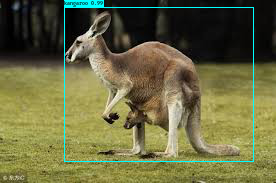

In [6]:
from PIL import Image
from yolo import YOLO
image = Image.open('test_1.jpg')
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image) 
r_image

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (38, 24) (167, 259)
0.14038737200007745


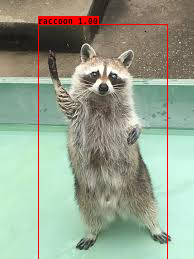

In [8]:
image = Image.open('test_3.jpg') 
r_image = yolo_model.detect_image(image) 
r_image

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (105, 45) (600, 366)
0.1483546849999584


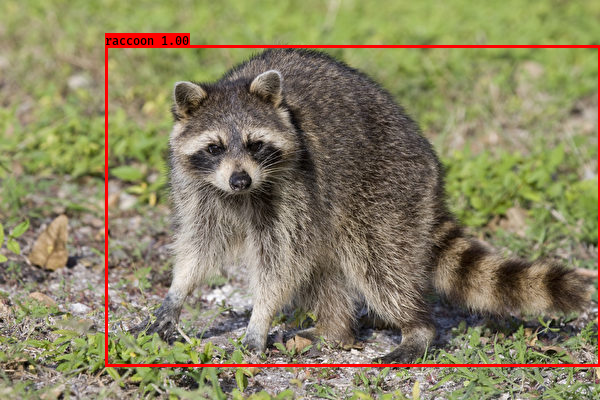

In [9]:
image = Image.open('test_4.jpg') 
r_image = yolo_model.detect_image(image) 
r_image

(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (0, 7) (600, 314)
0.14276848099984818


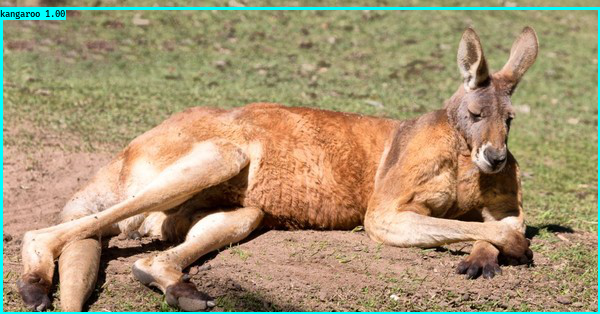

In [10]:
image = Image.open('test_2.jpg') 
r_image = yolo_model.detect_image(image) 
r_image